In [ ]:
https://github.com/SulemanRasheed/EEG-HandGrasp-Classification/blob/e64eef2ec459ee5dd5d9de0cf3f3074feae9da11/.ipynb_checkpoints/10.%20Cross%20Subject%20Classification%20with%20EEGNet%20-checkpoint.ipynb
    

In [1]:
import pandas as pd
import numpy as np
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws

from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import braindecode
braindecode.__version__

'0.6'

In [3]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\_MOT_BCI_\\src\\'
directory_data = 'D:\\PhD\\_MOT_BCI_\\data - raw\\'
directory_preproc = 'D:\\PhD\\_MOT_BCI_\\data - preprocessed\\'

In [4]:
filepath = directory_data + 'W10F2.bdf'#'T25F1.bdf' #'F12F2.bdf' #'T25F1.bdf'
raw = read_raw_bdf(filepath, preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

# Load Behav Data.
df_behav = pd.read_csv(filepath[:filepath.rfind('.')] + '.csv', sep=',')

# Rework Events based on Behav Data. (to add Side and SetSize information)
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        #if (nb_trials + 1) % 10 == 0:
            #print('Check Synch!')

# Working with modified events from now on.
events = new_events

# Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
print('==================================================')
print('Removing Events ID not in EEG File...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================') 

# Calculate average response time.
resp_time_in_ticks = []
for i, e in enumerate(events):
    if e[2] == 8:
        if events[i+1,2] == 32:
            resp_time_in_ticks.append(events[i+1,0] - events[i,0])
        elif events[i+1,2] == 16: #Synch?!
            if events[i+2,2] == 32:
                resp_time_in_ticks.append(events[i+2,0] - events[i,0])
            else:
                print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))
        else:
            print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))

mean_rt = np.mean(resp_time_in_ticks)
median_rt = np.median(resp_time_in_ticks)
std_rt = np.std(resp_time_in_ticks)
print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))

# Epoching
epochs = Epochs(raw, events, event_id=cur_event_id, tmin=0, tmax=14, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

Extracting EDF parameters from D:\PhD\_MOT_BCI_\data - raw\W10F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6434815  =      0.000 ...  3142.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Setting baseline interval to [0.0, 14.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 28673 original time points ...


C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped


In [35]:
#X = epochs.copy().pick_channels(['AF3']).get_data().squeeze()
X = epochs.get_data()
y = epochs.events[:, -1]
#y = np.array([str(x) for x in y])

In [5]:
# Manually adding left and right for classification (will merge all right and all left together)
ml_event_id = dict()
ml_event_id['ml_left'] = 1
ml_event_id['ml_right'] = -1

new_merged_events = mne.merge_events(events, [121, 221, 321], ml_event_id['ml_left']) # Only Good for now.
new_merged_events = mne.merge_events(new_merged_events, [111, 211, 311], ml_event_id['ml_right'])  # Only Good for now.
epochs = Epochs(raw, new_merged_events, event_id=ml_event_id, tmin=11, tmax=12.5, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

Not setting metadata
45 matching events found
Setting baseline interval to [11.0, 12.5] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 3073 original time points ...
0 bad epochs dropped


In [8]:
import pickle
with open('mne_test.pkl', 'wb') as f:
    pickle.dump(epochs, f)

In [9]:
windows_dataset = create_from_mne_epochs(
    [epochs],
    window_size_samples=len(epochs.times),
    window_stride_samples=50,
    drop_last_window=False
)

windows_dataset.description

Creating RawArray with float64 data, n_channels=64, n_times=3073
    Range : 0 ... 3072 =      0.000 ...     1.500 secs
Ready.
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=64, n_times=3073
    Range : 0 ... 3072 =      0.000 ...     1.500 secs
Ready.
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=64, n_times=3073
    Range : 0 ... 3072 =      0.000 ...     1.500 secs
Ready.
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=64, n_times=3073
    Range : 0 ... 3072 =      0.000 ...     1.500 secs
Ready.
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 d

Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...

,0
0,None


In [7]:
def get_windows_datasets_labels(windows_dataset):
    labels = []
    for i in range(len(windows_dataset.datasets)):
        labels.extend(windows_dataset.datasets[i].y)
    return np.array(labels) 

windows_dataset.description = pd.DataFrame(data=get_windows_datasets_labels(windows_dataset), 
                                           columns=['labels'])

AttributeError: can't set attribute

In [8]:
windows_dataset.set_description(pd.DataFrame(data=get_windows_datasets_labels(windows_dataset), columns=['labels']))

In [16]:
windows_dataset.datasets[0].y

[-1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1]

In [10]:

windows_dataset.get_metadata()['target']

0   -1
0   -1
0    1
0   -1
0    1
0   -1
0    1
0   -1
0    1
0    1
0    1
0   -1
0   -1
0    1
0   -1
0    1
0    1
0    1
0   -1
0    1
0   -1
0   -1
0   -1
0    1
0    1
0    1
0   -1
0   -1
0    1
0   -1
0   -1
0    1
0   -1
0    1
0   -1
0    1
0    1
0    1
0    1
0   -1
0   -1
0    1
0   -1
0    1
0    1
Name: target, dtype: int64

In [50]:
splitted = windows_dataset.split([list(range(30)), list(range(31, 45))])
train_set = splitted['0']
valid_set = splitted['1']

IndexError: list index out of range

In [53]:
windows_dataset.datasets[0].y

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1]

In [106]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
# Extract number of chans and time steps from dataset
n_chans = 67 #train_set[0][0].shape[0]
input_window_samples = 1024 #train_set[0][0].shape[1]

model = ShallowFBCSPNet( #EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

In [105]:
data_temp.shape

(45, 67, 1024)

In [64]:
y = windows_dataset.datasets[0].y

In [74]:
windows_dataset.get_metadata()

AttributeError: 'NoneType' object has no attribute 'items'

In [79]:
def get_windows_datasets_labels(windows_dataset):
    labels = []
    for i in range(len(windows_dataset.datasets)):
        labels.extend(windows_dataset.datasets[i].y)
    return np.array(labels) 

windows_dataset.set_description(pd.DataFrame(data=get_windows_datasets_labels(windows_dataset), columns=['targets']))

In [82]:
for i in range(len(windows_dataset.datasets)):
    print(windows_dataset.datasets[i].y)

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]


In [90]:
windows_dataset.__get_item__(4)

AttributeError: 'BaseConcatDataset' object has no attribute '__get_item__'

In [88]:
pd.DataFrame(data=get_windows_datasets_labels(windows_dataset), columns=['targets'])

,targets
0,0
1,0
2,1
3,0
4,1
5,0
6,1
7,0
8,1
9,1


In [107]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 4
n_epochs = 4

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    #train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)

clf.fit(data_temp, y=y, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.5556        7.9234            0.4444        1.5276  0.0006  1.8249
      2            0.5556        4.8681            0.4444       11.7869  0.0005  1.7980
      3            0.5556        3.5781            0.4444        2.4146  0.0002  1.7544
      4            0.5556        4.3217            0.4444        1.1047  0.0000  1.7704


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 67), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 2, kernel_size=(62, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

In [109]:
data_temp.shape

(45, 67, 1024)

In [104]:
type(data_temp)

numpy.ndarray

In [100]:
from skorch.utils import to_numpy
np.unique(to_numpy(y))

array([0., 1.], dtype=float16)

In [99]:
y = np.array(y, dtype=np.float16)

In [66]:
type(windows_dataset)

braindecode.datasets.base.BaseConcatDataset

In [59]:
X.shape

(67, 1024)

In [40]:
y.shape

(45,)

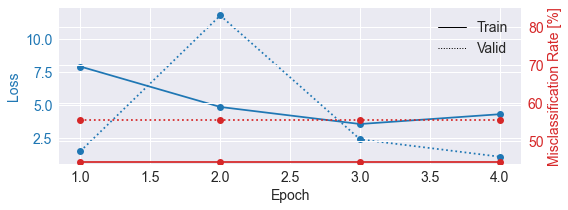

In [110]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...
Using data from preloaded Raw for 1 events and 3073 original time points ...

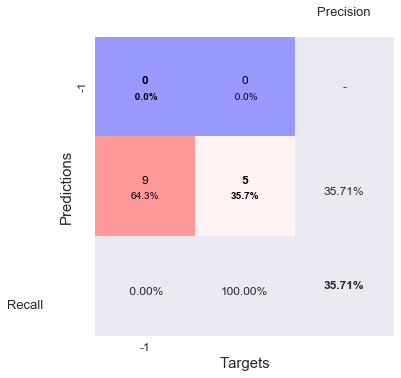

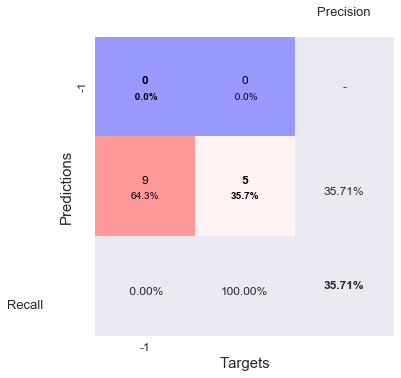

In [25]:
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = valid_set.datasets[0].windows.event_id.items()
# sort the labels by values (values are integer class labels)
labels = list(dict(sorted(list(label_dict), key=lambda kv: kv[1])).keys())

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)

In [54]:
train_set.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,labels
0,0,680049,683122,-1,-1
0,0,735983,739056,-1,-1
0,0,1004099,1007172,1,1
0,0,1187448,1190521,-1,-1
0,0,1243194,1246267,1,1
0,0,1369645,1372718,-1,-1
0,0,1489458,1492531,1,1
0,0,1557887,1560960,-1,-1
0,0,2063904,2066977,1,1
0,0,2251900,2254973,1,1


In [55]:
valid_set.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,labels
0,0,5192194,5195267,1,1
0,0,5251563,5254636,-1,-1
0,0,5425807,5428880,1,1
0,0,5481273,5484346,-1,-1
0,0,5650841,5653914,1,1
0,0,5706399,5709472,1,1
0,0,5761770,5764843,1,1
0,0,5822415,5825488,1,1
0,0,5886181,5889254,-1,-1
0,0,5955365,5958438,-1,-1


In [42]:
from braindecode.datasets.base import BaseDataset, BaseConcatDataset
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess

base_set = BaseDataset(raw)
dataset = BaseConcatDataset([base_set])
                       
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    MNEPreproc(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    #NumpyPreproc(fn=exponential_moving_standardize, factor_new=factor_new,
    #    init_block_size=init_block_size)
]

# Preprocess the data
#preprocess(dataset, preprocessors)

C:\Users\Yannick\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:67: FutureWarning: Class MNEPreproc is deprecated; will be removed in 0.7.0. Use Preprocessor with `apply_on_array=False` instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Yannick\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:67: FutureWarning: Class NumpyPreproc is deprecated; will be removed in 0.7.0. Use Preprocessor with `apply_on_array=True` instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Yannick\Miniconda3\lib\site-packages\braindecode\preprocessing\preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [43]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['-1', '1']
Adding metadata with 4 columns
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 1024 original time points ...
0 bad epochs dropped


In [44]:
windows_dataset

In [47]:
windows_dataset.datasets[0].y

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1]

In [14]:
dataset.datasets[0]

In [15]:
dataset.datasets[0][0]

(array([[-1.83867629e-02],
        [-1.94409172e-02],
        [-7.78625124e-03],
        [-7.03415888e-03],
        [-6.35922262e-03],
        [-5.33794326e-03],
        [-1.31433976e-02],
        [-1.09580579e-02],
        [-5.22063098e-03],
        [-8.10950064e-03],
        [-9.00162399e-03],
        [-8.71140578e-03],
        [-1.52129875e-02],
        [-9.79312253e-03],
        [-1.17281502e-02],
        [-1.10278390e-02],
        [-1.14640882e-02],
        [-7.56131415e-03],
        [-3.67063384e-03],
        [-1.41159895e-02],
        [-7.41372068e-03],
        [-6.52450357e-03],
        [ 5.47972425e-03],
        [-6.14119178e-03],
        [-7.81928243e-03],
        [-7.85243862e-03],
        [-6.57856597e-03],
        [-8.43918753e-03],
        [-5.32647453e-03],
        [-8.21725044e-03],
        [-1.02238717e-02],
        [ 6.97375274e-03],
        [-1.80994197e-02],
        [-1.75721082e-02],
        [-1.91614177e-02],
        [-1.72912024e-02],
        [-5.85222356e-03],
 

In [9]:
trial_start_offset_samples

-1024

In [ ]:
eog_events = mne.preprocessing.find_eog_events(raw)  
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / raw.info['sfreq'] - 0.25  
duration = np.repeat(0.5, n_blinks)  
description = ['bad blink'] * n_blinks  
annotations = mne.Annotations(onset, duration, description)  
raw.set_annotations(annotations)  
epochs = mne.Epochs(raw, events, event_id, tmin, tmax)  

In [17]:
event_id

{'1/right/good': 111,
 '1/right/bad': 112,
 '1/left/good': 121,
 '1/left/bad': 122,
 '1/classicmod/good': 131,
 '1/classicmod/bad': 132,
 '2/right/good': 211,
 '2/right/bad': 212,
 '2/left/good': 221,
 '2/left/bad': 222,
 '2/classicmod/good': 231,
 '2/classicmod/bad': 232,
 '3/right/good': 311,
 '3/right/bad': 312,
 '3/left/good': 321,
 '3/left/bad': 322,
 '3/classicmod/good': 331,
 '3/classicmod/bad': 332}

In [18]:
events

[[295447, 0, 312],
 [368799, 0, 322],
 [435762, 0, 212],
 [501539, 0, 222],
 [565434, 0, 131],
 [623937, 0, 131],
 [680049, 0, 111],
 [735983, 0, 211],
 [794351, 0, 331],
 [860028, 0, 322],
 [939854, 0, 312],
 [1004099, 0, 121],
 [1063550, 0, 332],
 [1128671, 0, 232],
 [1187448, 0, 111],
 [1243194, 0, 121],
 [1298490, 0, 312],
 [1369645, 0, 111],
 [1427291, 0, 231],
 [1489458, 0, 221],
 [1557887, 0, 211],
 [1875830, 0, 231],
 [1940069, 0, 222],
 [2002452, 0, 322],
 [2063904, 0, 221],
 [2124004, 0, 312],
 [2188402, 0, 331],
 [2251900, 0, 221],
 [2308422, 0, 312],
 [2368831, 0, 321],
 [2431024, 0, 331],
 [2521477, 0, 111],
 [2577443, 0, 211],
 [2635226, 0, 121],
 [2690702, 0, 111],
 [2745690, 0, 131],
 [2801665, 0, 121],
 [2858114, 0, 121],
 [2914290, 0, 321],
 [2978982, 0, 211],
 [3036360, 0, 131],
 [3093595, 0, 232],
 [3623970, 0, 221],
 [3681553, 0, 212],
 [3738897, 0, 311],
 [3808119, 0, 111],
 [3864231, 0, 211],
 [3921265, 0, 121],
 [3977507, 0, 121],
 [4032503, 0, 331],
 [4090518, 

In [36]:
ml_event_id = dict()
ml_event_id['ml_left'] = 1
ml_event_id['ml_right'] = -1

new_merged_events = mne.merge_events(events, [121, 221, 321], ml_event_id['ml_left']) # Only Good for now.
new_merged_events = mne.merge_events(new_merged_events, [111, 211, 311], ml_event_id['ml_right'])  # Only Good for now.

In [37]:
ml_events = new_merged_events[(new_merged_events[:,2] == -1) | (new_merged_events[:,2] == 1)]
ml_events

array([[ 680049,       0,      -1],
       [ 735983,       0,      -1],
       [1004099,       0,       1],
       [1187448,       0,      -1],
       [1243194,       0,       1],
       [1369645,       0,      -1],
       [1489458,       0,       1],
       [1557887,       0,      -1],
       [2063904,       0,       1],
       [2251900,       0,       1],
       [2368831,       0,       1],
       [2521477,       0,      -1],
       [2577443,       0,      -1],
       [2635226,       0,       1],
       [2690702,       0,      -1],
       [2801665,       0,       1],
       [2858114,       0,       1],
       [2914290,       0,       1],
       [2978982,       0,      -1],
       [3623970,       0,       1],
       [3738897,       0,      -1],
       [3808119,       0,      -1],
       [3864231,       0,      -1],
       [3921265,       0,       1],
       [3977507,       0,       1],
       [4149746,       0,       1],
       [4381639,       0,      -1],
       [4437684,       0,   

In [27]:
annotations = mne.Annotations(ml_events[:,0], ml_events[:,1], ml_events[:,2])  
raw.set_annotations(annotations)

<ipython-input-27-656e74a03586>:2: RuntimeWarning: Omitted 45 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<RawEDF | W10F2.bdf, 67 x 6434816 (3142.0 s), ~3.21 GB, data loaded>

In [41]:
raw.set_annotations(ml_anns)
raw.annotations

<Annotations | 45 segments: -1 (21), 1 (24)>

In [39]:
annotations[0]

OrderedDict([('onset', 680049.0),
             ('duration', 0.0),
             ('description', '-1'),
             ('orig_time', None)])

In [40]:
ml_anns = mne.annotations_from_events(ml_events, raw.info['sfreq'])
ml_anns

<Annotations | 45 segments: -1 (21), 1 (24)>

In [34]:
raw.ticks

AttributeError: 'RawEDF' object has no attribute 'ticks'

In [35]:
filepath = directory_data + 'W10F2.bdf'#'T25F1.bdf' #'F12F2.bdf' #'T25F1.bdf'
raw = read_raw_bdf(filepath, preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

# Load Behav Data.
df_behav = pd.read_csv(filepath[:filepath.rfind('.')] + '.csv', sep=',')

# Rework Events based on Behav Data. (to add Side and SetSize information)
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        #if (nb_trials + 1) % 10 == 0:
            #print('Check Synch!')

# Working with modified events from now on.
events = new_events

# Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
print('==================================================')
print('Removing Events ID not in EEG File...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================') 

# Calculate average response time.
resp_time_in_ticks = []
for i, e in enumerate(events):
    if e[2] == 8:
        if events[i+1,2] == 32:
            resp_time_in_ticks.append(events[i+1,0] - events[i,0])
        elif events[i+1,2] == 16: #Synch?!
            if events[i+2,2] == 32:
                resp_time_in_ticks.append(events[i+2,0] - events[i,0])
            else:
                print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))
        else:
            print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))

mean_rt = np.mean(resp_time_in_ticks)
median_rt = np.median(resp_time_in_ticks)
std_rt = np.std(resp_time_in_ticks)
print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))

# Epoching
epochs = Epochs(raw, events, event_id=cur_event_id, tmin=0, tmax=14, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

Extracting EDF parameters from D:\PhD\_MOT_BCI_\data - raw\W10F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6434815  =      0.000 ...  3142.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Setting baseline interval to [0.0, 14.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 28673 original time points ...


C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\Yannick\Miniconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped


In [56]:
X, y, (i_window_in_trial, i_start_sample, i_stop_sample) =  windows_dataset[0]

Text(0.5, 0, 'Timesteps')

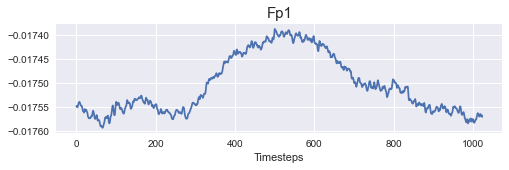

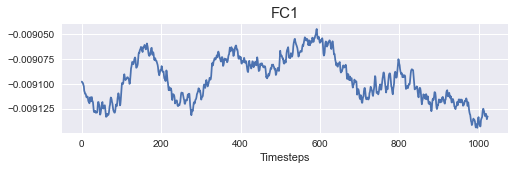

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[0]}", fontsize=15)
plt.xlabel("Timesteps")
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[10])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[10]}", fontsize=15)
plt.xlabel("Timesteps")

In [94]:
data_temp = windows_dataset.datasets[0].windows.get_data()
data_temp.shape

(45, 67, 1024)